In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy

In [2]:
def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape) * std
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])


# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

In [3]:
batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)


Epoch: 0
Mean Train Loss: 3.93e-01
Mean Test Loss:  2.73e-01
Epoch: 20
Mean Train Loss: 1.23e-01
Mean Test Loss:  4.71e-01
Epoch: 30
Mean Train Loss: 7.76e-02
Mean Test Loss:  6.36e-01
Epoch: 40
Mean Train Loss: 6.37e-02
Mean Test Loss:  6.67e-01
Epoch: 50
Mean Train Loss: 5.11e-02
Mean Test Loss:  9.61e-01
Epoch: 60
Mean Train Loss: 3.38e-02
Mean Test Loss:  7.57e-01
Epoch: 70
Mean Train Loss: 2.86e-02
Mean Test Loss:  8.95e-01
Epoch: 80
Mean Train Loss: 2.70e-02
Mean Test Loss:  8.00e-01
Epoch: 90
Mean Train Loss: 9.60e-03
Mean Test Loss:  8.92e-01
Epoch: 100
Mean Train Loss: 1.21e-02
Mean Test Loss:  1.03e+00


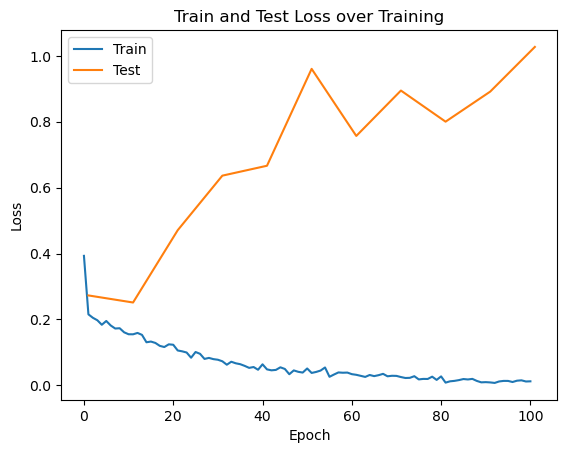

In [2]:
plt.rc("figure", dpi=100)

# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer = RMSprop(params=[w_h, w_h2, w_o])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = model(x, w_h, w_h2, w_o)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [4]:
def dropout(X, p_drop=0.5):
    if 0<p_drop<1:
        drop = np.random.binomial(1, p_drop, len(X))
        X[drop==1]=0
        X[drop==0]=X[drop==0]/(1-p_drop)
        return X
    else:
        return X

# define the neural network using dropout learning
def dropout_model(X, w_h, w_h2, w_o, p_drop_input, p_drop_hidden):
    X_drop = dropout(X,p_drop_input)
    h = rectify(X_drop @ w_h)
    h_drop = dropout(h,p_drop_hidden)
    h2 = rectify(h_drop @ w_h2)
    h2_drop = dropout(h2,p_drop_hidden)
    pre_softmax = h2_drop @ w_o
    return pre_softmax

## Dropout
Neural networks often tend to overfit the training data. To reduce overfitting one might use an ensembles of neural networks with different model configurations, but this requires a lot of additional computational expense training all models. By droping out neurons randomly one can simulate mutiple networks and reduce overfitting computationally cheap.
Dropout has the effect of making the training process noisy, forcing nodes within a layer to probabilistically take on more or less responsibility for the inputs.

Epoch: 0
Mean Train Loss: 2.63e+00
Mean Test Loss:  9.41e-01
Epoch: 10
Mean Train Loss: 2.27e+00
Mean Test Loss:  6.44e-01
Epoch: 20
Mean Train Loss: 2.26e+00
Mean Test Loss:  4.11e-01
Epoch: 30
Mean Train Loss: 2.25e+00
Mean Test Loss:  4.00e-01
Epoch: 40
Mean Train Loss: 2.25e+00
Mean Test Loss:  4.35e-01
Epoch: 50
Mean Train Loss: 2.25e+00
Mean Test Loss:  2.98e-01
Epoch: 60
Mean Train Loss: 2.24e+00
Mean Test Loss:  2.83e-01
Epoch: 70
Mean Train Loss: 2.25e+00
Mean Test Loss:  2.39e-01
Epoch: 80
Mean Train Loss: 2.25e+00
Mean Test Loss:  3.20e-01
Epoch: 90
Mean Train Loss: 2.25e+00
Mean Test Loss:  2.28e-01
Epoch: 100
Mean Train Loss: 2.25e+00
Mean Test Loss:  2.14e-01


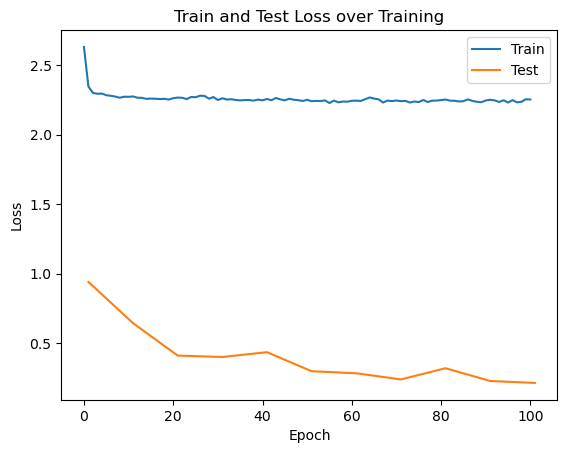

In [5]:
p_drop_input = 0.8
p_drop_hidden = 0.5

# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)

optimizer_drop = RMSprop(params=[w_h, w_h2, w_o])

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = dropout_model(x, w_h, w_h2, w_o, p_drop_input, p_drop_hidden)

        # reset the gradient
        optimizer_drop.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer_drop.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = model(x, w_h, w_h2, w_o)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

without the dropout model the testset error increases with the number of epochs, which is a sign for overfitting. Using the dropout functunality the testset error decreases with the number of epochs, which means we were able to reduce overfitting.

## Parametric Relu

In [5]:
def PRelu(x,a):
    for i in range(x.size(0)):
        inst = x[i]
        inst[inst<=0] = a[inst<=0]*inst[inst<=0]
    return x

# define the neural network
def PRmodel(x, w_h, w_h2, w_o, a, a2):
    #print(np.shape(x @ w_h))
    h = PRelu(x @ w_h, a)
    #print(np.shape(h @ w_h2))
    h2 = PRelu(h @ w_h2, a2)
    pre_softmax = h2 @ w_o
    return pre_softmax

<div style="color: green; font-weight: bold">Comment</div>
 Solution achieves correct results, but sample solution is more readable and more efficient, since it avoids redundant computations. The model missing the dropout layers as in the sample solution, however task doesn't clearly state to use the solution from 2.

In [ ]:
# initialize weights

# input shape is (B, 784)
w_h = init_weights((784, 625))
# hidden layer with 625 neurons
w_h2 = init_weights((625, 625))
# hidden layer with 625 neurons
w_o = init_weights((625, 10))
# output shape is (B, 10)
a = torch.zeros((625))
a.requires_grad = True

a2 = torch.zeros((625))
a2.requires_grad = True
 

PRoptimizer = RMSprop(params=[w_h, w_h2, w_o, a, a2])


n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # our model requires flattened input
        x = x.reshape(batch_size, 784)
        # feed input through model
        noise_py_x = PRmodel(x, w_h, w_h2, w_o, a, a2)

        # reset the gradient
        PRoptimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        PRoptimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch
                x = x.reshape(batch_size, 784)
                noise_py_x = PRmodel(x, w_h, w_h2, w_o, a, a2)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

Epoch: 0
Mean Train Loss: 4.09e-01
Mean Test Loss:  2.64e-01
Epoch: 10
Mean Train Loss: 1.02e-01
Mean Test Loss:  1.71e-01
Epoch: 20
Mean Train Loss: 6.78e-02
Mean Test Loss:  2.73e-01
Epoch: 30
Mean Train Loss: 5.24e-02
Mean Test Loss:  3.31e-01
Epoch: 40
Mean Train Loss: 5.38e-02
Mean Test Loss:  4.93e-01
Epoch: 50
Mean Train Loss: 4.31e-02
Mean Test Loss:  4.79e-01
Epoch: 60
Mean Train Loss: 4.20e-02
Mean Test Loss:  5.47e-01
Epoch: 70
Mean Train Loss: 3.58e-02
Mean Test Loss:  5.33e-01
Epoch: 80
Mean Train Loss: 3.36e-02
Mean Test Loss:  5.72e-01


<div style="color: green; font-weight: bold">Comment</div>
Very nice code, everything correct!

## Convolutional layers

In [ ]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout1 = torch.nn.Dropout2d(p=0.25)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout2 = torch.nn.Dropout2d(p=0.25)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=2, stride=1, padding=0)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout3 = torch.nn.Dropout2d(p=0.25)
        self.fc1 = torch.nn.Linear(128 * 3 * 3, 625)
        self.fc2 = torch.nn.Linear(625, 10)
        self.prelu = torch.nn.PReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.prelu(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.prelu(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.prelu(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        x = x.view(-1, 128 * 3 * 3)
        x = self.fc1(x)
        x = self.prelu(x)
        x = self.fc2(x)
        return x

model = ConvNet()

# move model to GPU if available
if torch.cuda.is_available():
    model = model.to("cuda")

optimizer = optim.RMSprop(model.parameters(), lr=1e-3, alpha=0.5, eps=1e-8)

n_epochs = 100

train_loss = []
test_loss = []

# put this into a training loop over 100 epochs
for epoch in range(n_epochs + 1):
    train_loss_this_epoch = []
    for idx, batch in enumerate(train_dataloader):
        x, y = batch

        # move data to GPU if available
        if torch.cuda.is_available():
            x = x.to("cuda")
            y = y.to("cuda")

        # feed input through model
        noise_py_x = model(x)

        # reset the gradient
        optimizer.zero_grad()

        # the cross-entropy loss function already contains the softmax
        loss = cross_entropy(noise_py_x, y, reduction="mean")

        train_loss_this_epoch.append(float(loss))

        # compute the gradient
        loss.backward()
        # update weights
        optimizer.step()

    train_loss.append(np.mean(train_loss_this_epoch))

    # test periodically
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
        print(f"Mean Train Loss: {train_loss[-1]:.2e}")
        test_loss_this_epoch = []

        # no need to compute gradients for validation
        with torch.no_grad():
            for idx, batch in enumerate(test_dataloader):
                x, y = batch

                # move data to GPU if available
                if torch.cuda.is_available():
                    x = x.to("cuda")
                    y = y.to("cuda")

                noise_py_x = model(x)

                loss = cross_entropy(noise_py_x, y, reduction="mean")
                test_loss_this_epoch.append(float(loss))

        test_loss.append(np.mean(test_loss_this_epoch))

        print(f"Mean Test Loss:  {test_loss[-1]:.2e}")

plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
plt.plot(np.arange(1, n_epochs + 2, 10), test_loss, label="Test")
plt.title("Train and Test Loss over Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Epoch: 0
Mean Train Loss: 2.12e-01
Mean Test Loss:  8.64e-02
Epoch: 10
Mean Train Loss: 5.03e-02
Mean Test Loss:  6.06e-02


In [ ]:
import matplotlib.pyplot as plt

# get one image from the test set
x, y = next(iter(test_dataloader))
img = x[0]

# plot the original image
plt.imshow(img[0], cmap="gray")
plt.title("Original Image")
plt.show()

# apply the first convolutional layer to the image
conv_img = model.conv1(img.unsqueeze(0).cuda()).detach().cpu()

# plot the convolved images with the filters
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(conv_img[0][i], cmap="gray")
    plt.title(f"Convolved image {i+1}")
plt.show()

# get the weights of the first convolutional layer
weights = model.conv1.weight.detach().cpu()

# plot the filter weights as 5x5 images
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(weights[i][0], cmap="gray")
    plt.title(f"Filter {i+1}")
plt.show()

Unfortunately the code took too much time for it to be done by the deadline. We therefore dont have the plotted convolved images but only the code.